In [1]:
import pandas as pd
import numpy as np
import random

np.random.seed(42)
random.seed(42)

# Generate sample data for 10 clients
data = []
num_clients = 10
start_year = 2017
end_year = 2023
months = (end_year - start_year) * 12

for client_id in range(1, num_clients + 1):
    for month_offset in range(months):
        year = start_year + month_offset // 12
        month = (month_offset % 12) + 1
        reporting_month = int(f"{year:04}{month:02}")
        revenue = round(random.uniform(1000, 10000), 2)
        data.append([client_id, reporting_month, revenue])

df = pd.DataFrame(data, columns=["client_id", "reporting_month", "revenue"])
df.to_csv("sample_data.csv", index=False)


## Approach-1

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv("sample_data.csv")

# Preprocess the data
df["revenue_change"] = df.groupby("client_id")["revenue"].pct_change()
df["target"] = (df["revenue_change"] > 0).astype(int)
df.dropna(inplace=True)

# Prepare the features and target
X = df[["client_id", "reporting_month", "revenue"]]
y = df["target"]

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred))

# Predict the percentage of chances for revenue to go up or down
probs = model.predict_proba(X_test)
print("Probabilities:", probs)


Accuracy: 0.7676056338028169
Confusion Matrix: [[54 19]
 [14 55]]
Probabilities: [[0.14700256 0.85299744]
 [0.14760869 0.85239131]
 [0.12008672 0.87991328]
 [0.50148245 0.49851755]
 [0.88741177 0.11258823]
 [0.31795175 0.68204825]
 [0.90038018 0.09961982]
 [0.08916217 0.91083783]
 [0.37872946 0.62127054]
 [0.12454648 0.87545352]
 [0.60335204 0.39664796]
 [0.86283819 0.13716181]
 [0.87638158 0.12361842]
 [0.48567997 0.51432003]
 [0.11095018 0.88904982]
 [0.34728172 0.65271828]
 [0.7860629  0.2139371 ]
 [0.23133055 0.76866945]
 [0.40062888 0.59937112]
 [0.16826277 0.83173723]
 [0.87049961 0.12950039]
 [0.33760323 0.66239677]
 [0.77785787 0.22214213]
 [0.29671279 0.70328721]
 [0.37278834 0.62721166]
 [0.21636868 0.78363132]
 [0.56813    0.43187   ]
 [0.76054909 0.23945091]
 [0.76977558 0.23022442]
 [0.15750037 0.84249963]
 [0.72617684 0.27382316]
 [0.32982731 0.67017269]
 [0.15397988 0.84602012]
 [0.5240581  0.4759419 ]
 [0.81532351 0.18467649]
 [0.31267656 0.68732344]
 [0.10704366 0.8929

## Approach-2

In [19]:
#!conda install -c anaconda ephem -y
#!conda install -c conda-forge pystan -y
!conda install -c conda-forge fbprophet -y
#!pip install fbprophet


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: / ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



In [ ]:
import pandas as pd
import numpy as np
import random
from fbprophet import Prophet

np.random.seed(42)
random.seed(42)

# Load the data
df = pd.read_csv("sample_data.csv")

# Reshape the data into the required format for Prophet
df["reporting_month"] = pd.to_datetime(df["reporting_month"], format="%Y%m")
data = []

for client_id in df["client_id"].unique():
    temp_df = df[df["client_id"] == client_id][["reporting_month", "revenue"]]
    temp_df.rename(columns={"reporting_month": "ds", "revenue": "y"}, inplace=True)
    data.append(temp_df)

# Train and evaluate models for each client
for i, client_data in enumerate(data):
    # Split the data into training and testing sets
    train_data = client_data[:-12]
    test_data = client_data[-12:]

    # Train the model
    model = Prophet()
    model.fit(train_data)

    # Predict the future revenue
    future = model.make_future_dataframe(periods=12, freq="MS")
    forecast = model.predict(future)

    # Calculate the percentage of chances for revenue to go up or down
    forecast["yhat_diff"] = forecast["yhat"].diff()
    forecast["yhat_diff_pct"] = forecast["yhat_diff"] / forecast["yhat"].shift(1)
    forecast["direction"] = (forecast["yhat_diff_pct"] > 0).astype(int)

    # Evaluate the model
    test_results = forecast[-12:]
    actual_direction = (test_data["y"].pct_change().shift(-1) > 0).astype(int).values
    predicted_direction = test_results["direction"].values
    accuracy = np.mean(predicted_direction == actual_direction)

    print(f"Client {i + 1} accuracy: {accuracy}")


In [ ]:
import matplotlib.pyplot as plt

def plot_trend_and_seasonality(model, forecast):
    fig = model.plot_components(forecast)
    plt.show()

# Choose the index of the client you want to visualize (e.g., 0 for the first client)
client_index = 0
client_data = data[client_index]

# Train the model
model = Prophet()
model.fit(client_data)

# Predict the future revenue
future = model.make_future_dataframe(periods=12, freq="MS")
forecast = model.predict(future)

# Plot the trend, seasonality, and components
plot_trend_and_seasonality(model, forecast)



## Approach-3

In [12]:
#!pip install numpy
#!pip install sklearn --user
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org pip install --upgrade pip

!pip install --upgrade pycaret ipywidgets
#!pip install pycaret-ts-alpha ipywidgets
#!pip install numpy

,Description,Value
0,session_id,42
1,Target,revenue
2,Original Data,"(69, 5)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(55, 4)"


Dropdown(description='Client ID:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2093.4645,6098553.2789,2469.5249,0.0661,0.6359,0.7270


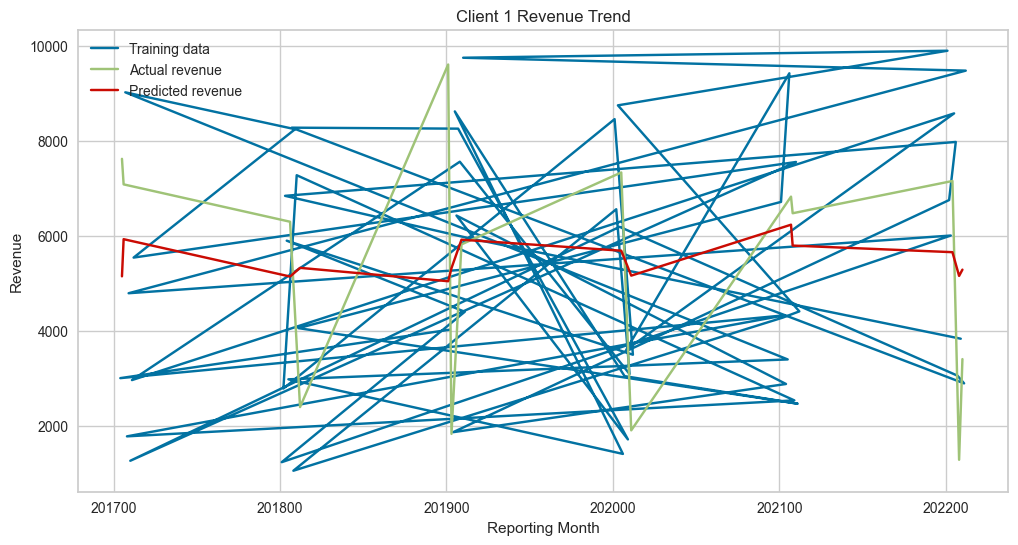

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2201.2986,7255669.2458,2693.6350,0.1515,0.6850,0.8146


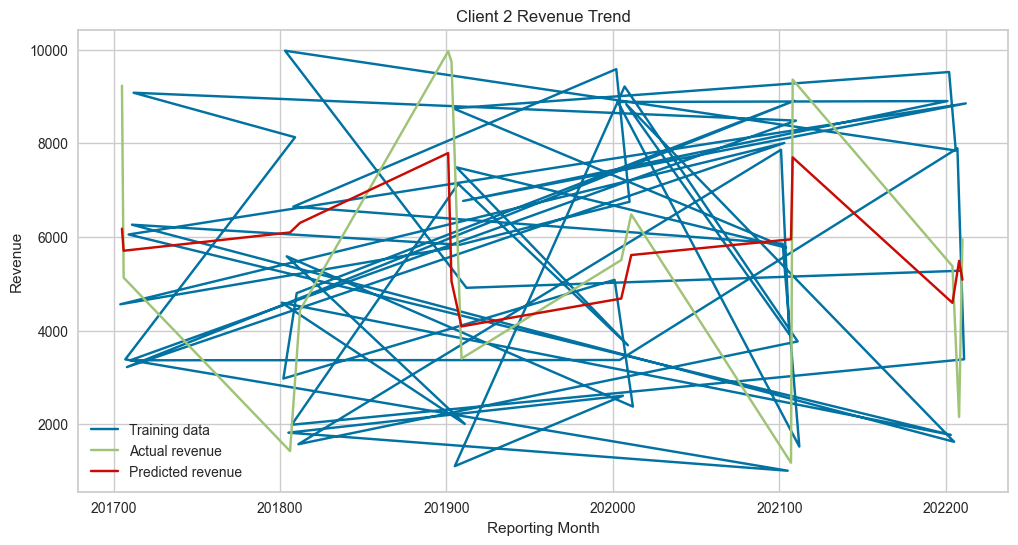

/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs

/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/tree/_classes.py:1254: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/tree/_classes.py:1262: FutureWarning: the n_classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/tree/_classes.py:1254: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/tree/_classes.py:1262: FutureWarning: the n_classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-package

/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/tree/_classes.py:1262: FutureWarning: the n_classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/tree/_classes.py:1254: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/tree/_classes.py:1262: FutureWarning: the n_classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2992256.0, tolerance: 42949.56640625
  model = cd_fast.enet_coordinat

/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs

/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs

/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: The outputs_2d_ attribute is deprecated in version 0.22 and will be removed in version 0.24. It is equivalent to n_outputs_ > 1.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: The outputs_2d_ attribute is deprecated in version 0.22 and will be removed in version 0.24. It is equivalent to n_outputs_ > 1.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: The outputs_2d_ attribute is deprecated in version 0.22 and will be removed in version 0.24. It is equivalent to n_outputs_ > 1.
  warnings.warn(msg, category=FutureWarning)
/Users/Dhaval/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did 

In [3]:
import pandas as pd
import numpy as np
import random
from pycaret.regression import setup, compare_models, create_model, predict_model
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
random.seed(42)

# Load the data
df = pd.read_csv("sample_data.csv")

# Function to create lagged features
def create_lagged_features(df, num_lags):
    lagged_df = df.copy()
    for i in range(1, num_lags + 1):
        lagged_df[f"revenue_lag_{i}"] = lagged_df["revenue"].shift(i)
    lagged_df.dropna(inplace=True)
    return lagged_df

# Create lagged features
num_lags = 3
df = df.groupby("client_id").apply(create_lagged_features, num_lags=num_lags).reset_index(drop=True)

# Function to train a model using PyCaret
def train_pycaret_model(client_data):
    # Set up the environment
    reg = setup(
        data=client_data,
        target="revenue",
        train_size=0.8,
        silent=True,
        verbose=True,
        session_id=42,
    )

    # Train the best model (you can choose a specific model if you prefer)
    best_model = compare_models(verbose=False)

    return best_model

# Train models for each client
models = []
for client_id in df["client_id"].unique():
    client_data = df[df["client_id"] == client_id].drop("client_id", axis=1)
    model = train_pycaret_model(client_data)
    models.append(model)

# Function to plot the trend for a specific client
def plot_client_trend(client_id):
    client_data = df[df["client_id"] == client_id].drop("client_id", axis=1)
    train_data = client_data.sample(frac=0.8, random_state=42)
    test_data = client_data.drop(train_data.index)

    model = models[client_id - 1]

    # Predict the revenue
    predictions = predict_model(model, data=test_data)

    # Plot the trend
    plt.figure(figsize=(12, 6))
    plt.plot(train_data["reporting_month"], train_data["revenue"], label="Training data")
    plt.plot(test_data["reporting_month"], test_data["revenue"], label="Actual revenue")
    plt.plot(test_data["reporting_month"], predictions["Label"], label="Predicted revenue")
    plt.xlabel("Reporting Month")
    plt.ylabel("Revenue")
    plt.title(f"Client {client_id} Revenue Trend")
    plt.legend()
    plt.show()


# Create the interactive dashboard
def on_client_dropdown_change(change):
    if change["type"] == "change" and change["name"] == "value":
        plot_client_trend(change["new"])

client_dropdown = widgets.Dropdown(
    options=sorted(df["client_id"].unique()),
    value=1,
    description="Client ID:",
)

client_dropdown.observe(on_client_dropdown_change)
display(client_dropdown)

# Plot the trend for the first client by default
plot_client_trend(1)

In [13]:
import pandas as pd
import numpy as np
import random
from pycaret.regression import setup, create_model, predict_model
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

# Load the data
df = pd.read_csv("sample_data.csv")

# Function to create lagged features
def create_lagged_features(df, num_lags):
    lagged_df = df.copy()
    for i in range(1, num_lags + 1):
        lagged_df[f"revenue_lag_{i}"] = lagged_df["revenue"].shift(i)
    lagged_df.dropna(inplace=True)
    return lagged_df

# Create lagged features
num_lags = 3
df = df.groupby("client_id").apply(create_lagged_features, num_lags=num_lags).reset_index(drop=True)

# Function to train a model using PyCaret
def train_pycaret_model(client_data):
    # Set up the environment
    reg = setup(
        data=client_data,
        target="revenue",
        train_size=0.8,
        silent=True,
        verbose=False,
        html=False,
        session_id=42,
    )

    # Train a specific model (e.g., Random Forest Regressor)
    best_model = create_model("rf", verbose=False)

    return best_model

# Train models for each client
models = []
for client_id in df["client_id"].unique():
    client_data = df[df["client_id"] == client_id].drop("client_id", axis=1)
    model = train_pycaret_model(client_data)
    models.append(model)

# Function to plot the trend for a specific client
def plot_client_trend(client_id, num_future_months=3):
    client_data = df[df["client_id"] == client_id].drop("client_id", axis=1)
    client_data["reporting_month"] = (pd.to_datetime(client_data["reporting_month"]).dt.year - 2017) * 12 + pd.to_datetime(client_data["reporting_month"]).dt.month - 1
    
    train_data = client_data.sample(frac=0.8, random_state=42)
    test_data = client_data.drop(train_data.index)

    model = models[client_id - 1]

    # Predict the revenue for test data
    predictions_test = predict_model(model, data=test_data)

    # Create a DataFrame for future months
    last_month_num = client_data["reporting_month"].max()
    future_month_nums = range(last_month_num + 1, last_month_num + num_future_months + 1)
    future_data = pd.DataFrame({"reporting_month": future_month_nums})
    
    # Create lagged features for future_data
    for i in range(1, num_lags + 1):
        future_data[f"revenue_lag_{i}"] = np.append(client_data["revenue"].tail(i).values, predictions_test["Label"].head(num_future_months - i).values)

    # Predict the revenue for future months
    predictions_future = predict_model(model, data=future_data)

    # Concatenate actual, test, and future data
    data = pd.concat([client_data, test_data, future_data], ignore_index=True)
    predictions = pd.concat([predictions_test, predictions_future], ignore_index=True)

    # Convert reporting_month back to datetime
    data["reporting_month"] = pd.to_datetime('2017-01-01') + pd.to_timedelta(data["reporting_month"], unit="M")
    predictions["reporting_month"] = pd.to_datetime('2017-01-01') + pd.to_timedelta(predictions["reporting_month"], unit="M")

    # Plot the trend
    plt.figure(figsize=(12, 6))
    plt.plot(data["reporting_month"], data["revenue"], label="Actual revenue")
    plt.plot(predictions["reporting_month"], predictions["Label"], label="Predicted revenue")
    plt.xlabel("Reporting Month")
    plt.ylabel("Revenue")
    plt.title(f"Client {client_id} Revenue Trend")
    plt.legend()
    plt.grid(True)
    plt.show()


# Create the interactive dashboard
def on_client_dropdown_change(change):
    if change["type"] == "change" and change["name"] == "value":
        plot_client_trend(change["new"])

client_dropdown = widgets.Dropdown(
    options=sorted(df["client_id"].unique()),
    value=1,
    description="Client ID:",
)

client_dropdown.observe(on_client_dropdown_change)
display(client_dropdown)

# Plot the trend for the first client by default
plot_client_trend(1)


Dropdown(description='Client ID:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1589.556,4055986.346,2013.948,0.3789,0.5812,0.6324


ValueError: Units 'M', 'Y', and 'y' are no longer supported, as they do not represent unambiguous timedelta values durations.

In [14]:
!pip install prophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 3.6 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.9 MB/s eta 0:00:00
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached holidays-0.21.13-py3-none-any.whl (378 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached korean_lunar_calendar-0.3.1-py3-none-any.whl (9.0 kB)
  Using cached backports.zoneinfo-0.2.1-cp38-cp38-macosx_10_14_x86_64.whl (35 kB)
  Using cached hijri_converter-2.2.4-py3-none-any.whl (14 kB)
  Using cached ephem-4.1.4-cp38-cp38-macosx_10_9_x86_64.whl (1.4 MB)


16:34:31 - cmdstanpy - INFO - Chain [1] start processing
16:34:31 - cmdstanpy - INFO - Chain [1] done processing
16:34:31 - cmdstanpy - INFO - Chain [1] start processing
16:34:31 - cmdstanpy - INFO - Chain [1] done processing
16:34:31 - cmdstanpy - INFO - Chain [1] start processing
16:34:32 - cmdstanpy - INFO - Chain [1] done processing
16:34:32 - cmdstanpy - INFO - Chain [1] start processing
16:34:32 - cmdstanpy - INFO - Chain [1] done processing
16:34:32 - cmdstanpy - INFO - Chain [1] start processing
16:34:32 - cmdstanpy - INFO - Chain [1] done processing
16:34:32 - cmdstanpy - INFO - Chain [1] start processing
16:34:32 - cmdstanpy - INFO - Chain [1] done processing
16:34:32 - cmdstanpy - INFO - Chain [1] start processing
16:34:32 - cmdstanpy - INFO - Chain [1] done processing
16:34:33 - cmdstanpy - INFO - Chain [1] start processing
16:34:33 - cmdstanpy - INFO - Chain [1] done processing
16:34:33 - cmdstanpy - INFO - Chain [1] start processing
16:34:33 - cmdstanpy - INFO - Chain [1]

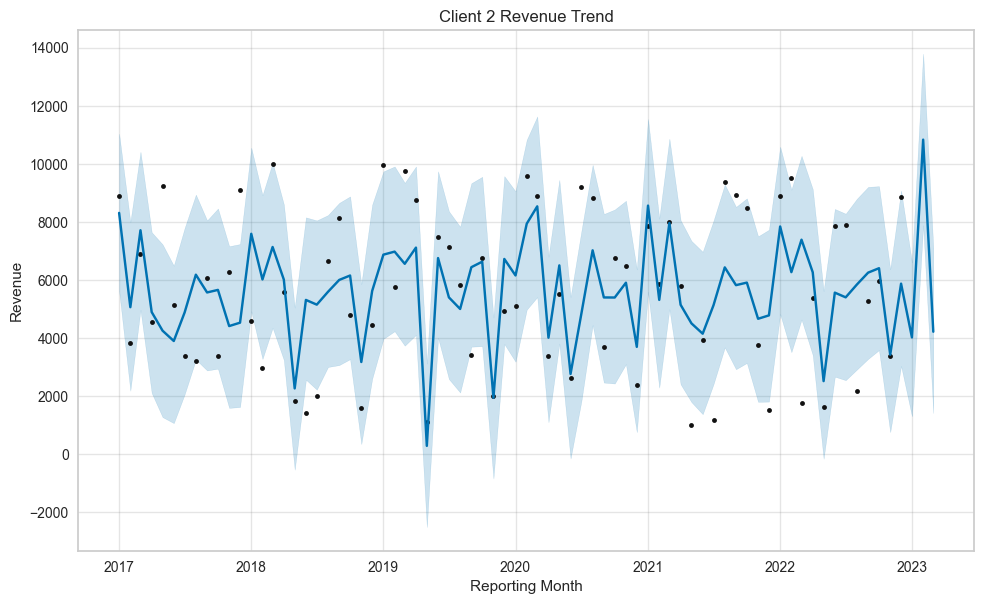

In [16]:
import pandas as pd
import numpy as np
import random
from prophet import Prophet
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

# Load the data
df = pd.read_csv("sample_data.csv")

# Convert 'reporting_month' to datetime
df["reporting_month"] = pd.to_datetime(df["reporting_month"], format="%Y%m")

# Function to train a model using Prophet
def train_prophet_model(client_data):
    client_data = client_data.rename(columns={"reporting_month": "ds", "revenue": "y"})
    
    model = Prophet(weekly_seasonality=False, daily_seasonality=False)
    model.fit(client_data)
    
    return model

# Train models for each client
models = []
for client_id in df["client_id"].unique():
    client_data = df[df["client_id"] == client_id][["reporting_month", "revenue"]]
    model = train_prophet_model(client_data)
    models.append(model)

# Function to plot the trend for a specific client
def plot_client_trend(client_id, num_future_months=3):
    client_data = df[df["client_id"] == client_id][["reporting_month", "revenue"]]

    model = models[client_id - 1]

    # Create a DataFrame for future months
    future = model.make_future_dataframe(periods=num_future_months, freq="M")
    
    # Predict the revenue
    predictions = model.predict(future)
    
    # Plot the trend
    fig = model.plot(predictions)
    plt.title(f"Client {client_id} Revenue Trend")
    plt.xlabel("Reporting Month")
    plt.ylabel("Revenue")
    plt.show()

plot_client_trend(2)


Dropdown(description='Client ID:', index=3, options=(1, 2, 3, 4, 5), value=4)

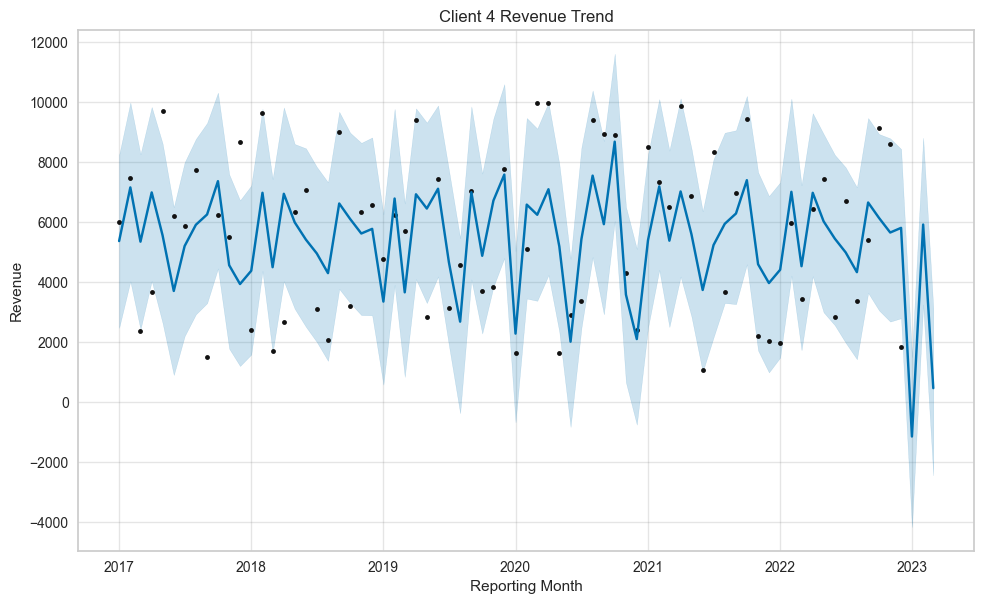

In [18]:
import pandas as pd
import numpy as np
import random
from prophet import Prophet
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

np.random.seed(42)
random.seed(42)

# Load the data
df = pd.read_csv("sample_data.csv")

# Convert 'reporting_month' to datetime
df["reporting_month"] = pd.to_datetime(df["reporting_month"], format="%Y%m")

# Function to train a model using Prophet
def train_prophet_model(client_data):
    client_data = client_data.rename(columns={"reporting_month": "ds", "revenue": "y"})
    
    model = Prophet(weekly_seasonality=False, daily_seasonality=False)
    model.fit(client_data)
    
    return model

# Train models for each client
models = []
for client_id in df["client_id"].unique():
    client_data = df[df["client_id"] == client_id][["reporting_month", "revenue"]]
    model = train_prophet_model(client_data)
    models.append(model)

# Function to plot the trend for a specific client
def plot_client_trend(client_id, num_future_months=3):
    client_data = df[df["client_id"] == client_id][["reporting_month", "revenue"]]

    model = models[client_id - 1]

    # Create a DataFrame for future months
    future = model.make_future_dataframe(periods=num_future_months, freq="M")
    
    # Predict the revenue
    predictions = model.predict(future)
    
    # Plot the trend
    fig = model.plot(predictions)
    plt.title(f"Client {client_id} Revenue Trend")
    plt.xlabel("Reporting Month")
    plt.ylabel("Revenue")
    plt.show()

# Interactive dashboard
def on_client_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(client_dropdown)
        plot_client_trend(change['new'])

selected_clients = [1, 2, 3, 4, 5]  # Add the client IDs you want to display in the dropdown
client_dropdown = widgets.Dropdown(options=selected_clients, description='Client ID:')
client_dropdown.observe(on_client_dropdown_change)
display(client_dropdown)


Dropdown(description='Client ID:', index=3, options=(1, 2, 3, 4, 5), value=4)

Revenue is likely to decrease by 4.14% in the next quarter.


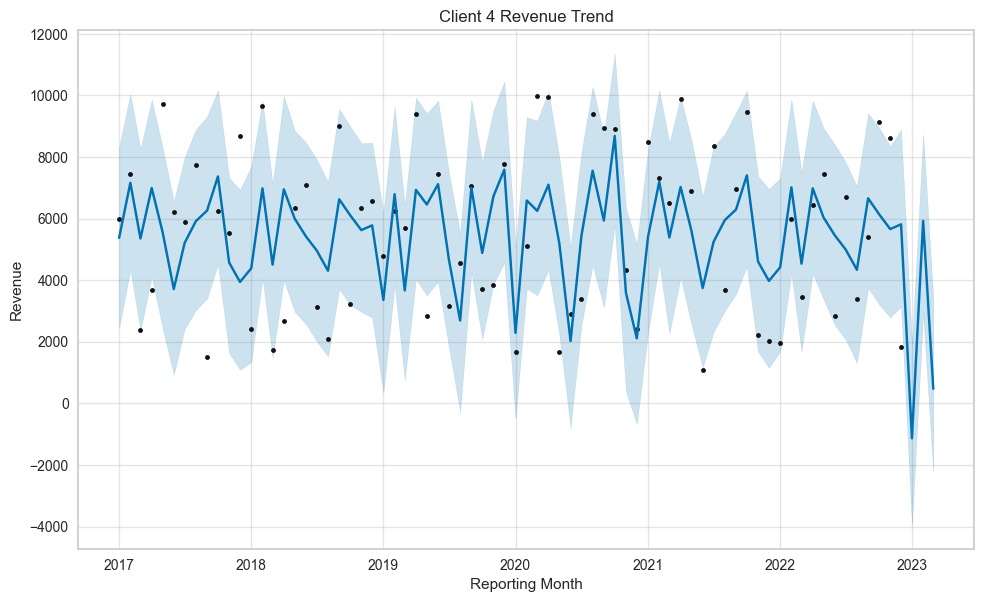

Trend component: The trend component represents the overall growth or decline in the revenue over time.
Seasonal component: The seasonal component represents the recurring patterns in the revenue data, such as monthly or yearly seasonality.


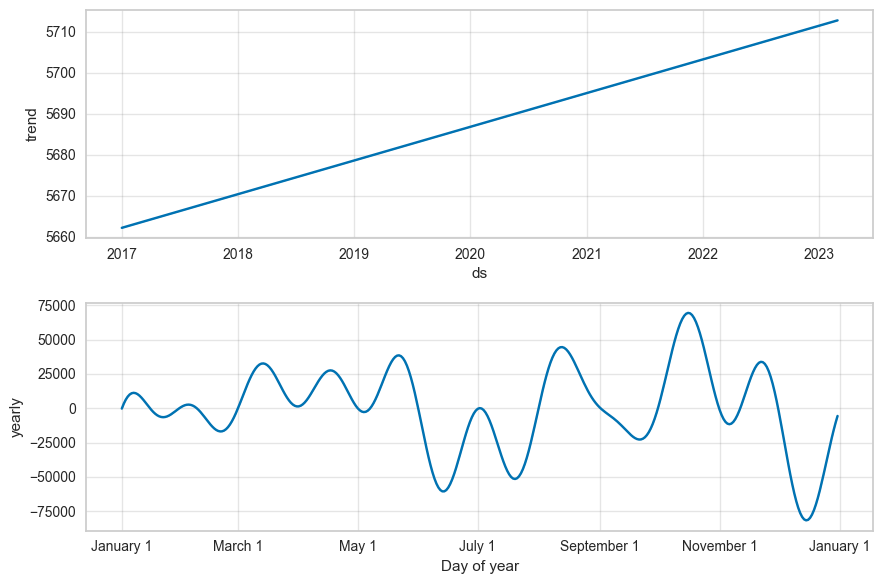

In [21]:
import pandas as pd
import numpy as np
import random
from prophet import Prophet
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

np.random.seed(42)
random.seed(42)

# Load the data
df = pd.read_csv("sample_data.csv")

# Convert 'reporting_month' to datetime
df["reporting_month"] = pd.to_datetime(df["reporting_month"], format="%Y%m")

# Function to train a model using Prophet
def train_prophet_model(client_data):
    client_data = client_data.rename(columns={"reporting_month": "ds", "revenue": "y"})
    
    model = Prophet(weekly_seasonality=False, daily_seasonality=False)
    model.fit(client_data)
    
    return model

# Train models for each client
models = []
for client_id in df["client_id"].unique():
    client_data = df[df["client_id"] == client_id][["reporting_month", "revenue"]]
    model = train_prophet_model(client_data)
    models.append(model)

# Function to plot the trend for a specific client
def plot_client_trend(client_id, num_future_months=3):
    client_data = df[df["client_id"] == client_id][["reporting_month", "revenue"]]

    model = models[client_id - 1]

    # Create a DataFrame for future months
    future = model.make_future_dataframe(periods=num_future_months, freq="M")
    
    # Predict the revenue
    predictions = model.predict(future)
    
    # Calculate the percentage change between the last known revenue and the average predicted revenue for the next quarter
    last_known_revenue = client_data.iloc[-1]["revenue"]
    avg_predicted_revenue = predictions.iloc[-num_future_months:]["yhat"].mean()
    percentage_change = ((avg_predicted_revenue - last_known_revenue) / last_known_revenue) * 100

    summary = f"Revenue is likely to {'increase' if percentage_change >= 0 else 'decrease'} by {abs(percentage_change):.2f}% in the next quarter."
    print(summary)

    # Plot the trend
    fig = model.plot(predictions)
    plt.title(f"Client {client_id} Revenue Trend")
    plt.xlabel("Reporting Month")
    plt.ylabel("Revenue")
    plt.show()

    print("Trend component: The trend component represents the overall growth or decline in the revenue over time.")
    print("Seasonal component: The seasonal component represents the recurring patterns in the revenue data, such as monthly or yearly seasonality.")
    
    # Plot the components
    fig = model.plot_components(predictions)
    plt.show()



# Interactive dashboard
def on_client_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(client_dropdown)
        plot_client_trend(change['new'])

selected_clients = [1, 2, 3, 4, 5]  # Add the client IDs you want to display in the dropdown
client_dropdown = widgets.Dropdown(options=selected_clients, description='Client ID:')
client_dropdown.observe(on_client_dropdown_change)
display(client_dropdown)


Dropdown(description='Client ID:', index=3, options=(1, 2, 3, 4, 5), value=4)

Revenue is likely to increase by 338.45% in the next quarter.


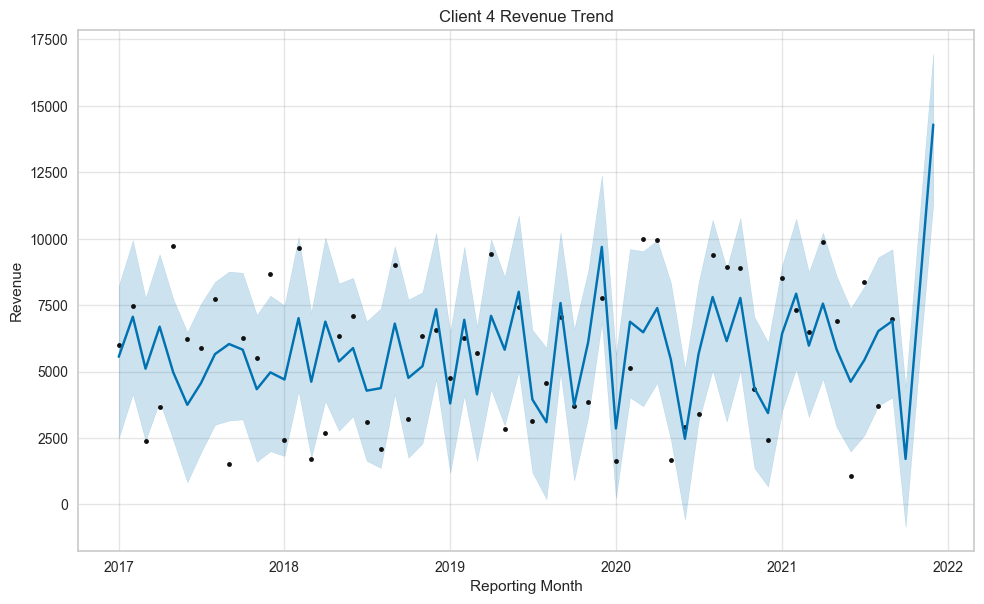

Trend component: The trend component represents the overall growth or decline in the revenue over time.
Seasonal component: The seasonal component represents the recurring patterns in the revenue data, such as monthly or yearly seasonality.


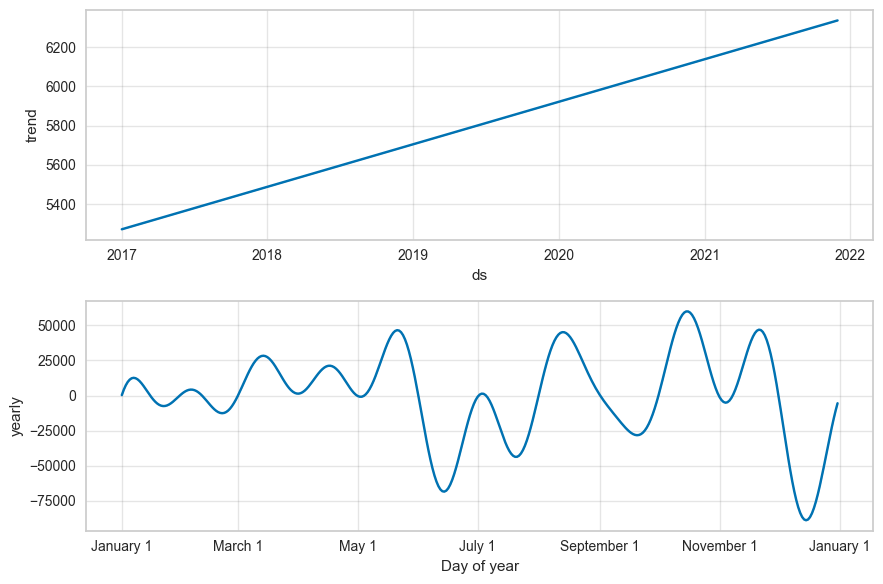

In [25]:
import pandas as pd
import numpy as np
import random
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

np.random.seed(42)
random.seed(42)

# Load the data
df = pd.read_csv("sample_data.csv")

# Convert 'reporting_month' to datetime
df["reporting_month"] = pd.to_datetime(df["reporting_month"], format="%Y%m")

# Function to train a model using Prophet
def train_prophet_model(client_data):
    client_data = client_data.rename(columns={"reporting_month": "ds", "revenue": "y"})
    
    # Split the data into train and test sets
    train_size = int(0.8 * len(client_data))
    train_data = client_data.iloc[:train_size]
    test_data = client_data.iloc[train_size:]

    # Train the model on the train set
    model = Prophet(weekly_seasonality=False, daily_seasonality=False)
    model.fit(train_data)
    
    # Make predictions on the test set
    predictions = model.predict(test_data[["ds"]])

    # Calculate the accuracy of the model on the test set
    mae = mean_absolute_error(test_data["y"], predictions["yhat"])
    mse = mean_squared_error(test_data["y"], predictions["yhat"])
    r2 = r2_score(test_data["y"], predictions["yhat"])

    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R2: {r2:.2f}")

    return model

# Train models for each client
models = []
for client_id in df["client_id"].unique():
    client_data = df[df["client_id"] == client_id][["reporting_month", "revenue"]]
    model = train_prophet_model(client_data)
    models.append(model)
    
    
# Function to plot the trend and components for a specific client
def plot_client_trend(client_id, num_future_months=3):
    client_data = df[df["client_id"] == client_id][["reporting_month", "revenue"]]

    model = models[client_id - 1]

    # Create a DataFrame for future months
    future = model.make_future_dataframe(periods=num_future_months, freq="M")
    
    # Predict the revenue
    predictions = model.predict(future)
    
    # Calculate the percentage change between the last known revenue and the average predicted revenue for the next quarter
    last_known_revenue = client_data.iloc[-1]["revenue"]
    avg_predicted_revenue = predictions.iloc[-num_future_months:]["yhat"].mean()
    percentage_change = ((avg_predicted_revenue - last_known_revenue) / last_known_revenue) * 100

    summary = f"Revenue is likely to {'increase' if percentage_change >= 0 else 'decrease'} by {abs(percentage_change):.2f}% in the next quarter."
    print(summary)

    # Plot the trend
    fig = model.plot(predictions)
    plt.title(f"Client {client_id} Revenue Trend")
    plt.xlabel("Reporting Month")
    plt.ylabel("Revenue")
    
    # Add the predicted revenue for the next quarter to the plot
    last_month = client_data["reporting_month"].iloc[-1]
    next_quarter = pd.date_range(start=last_month + pd.DateOffset(months=1), periods=num_future_months, freq="M")
    predicted_revenue = predictions.iloc[-num_future_months:]["yhat"]
    plt.plot(next_quarter, predicted_revenue, label="Predicted revenue for next quarter", linestyle="--")
    plt.legend()
    
    plt.show()

    print("Trend component: The trend component represents the overall growth or decline in the revenue over time.")
    print("Seasonal component: The seasonal component represents the recurring patterns in the revenue data, such as monthly or yearly seasonality.")


def plot_client_trend(client_id, num_future_months=3):
    client_data = df[df["client_id"] == client_id][["reporting_month", "revenue"]]

    model = models[client_id - 1]

    # Create a DataFrame for future months
    future = model.make_future_dataframe(periods=num_future_months, freq="M")
    
    # Predict the revenue
    predictions = model.predict(future)
    
    # Calculate the percentage change between the last known revenue and the average predicted revenue for the next quarter
    last_known_revenue = client_data.iloc[-1]["revenue"]
    avg_predicted_revenue = predictions.iloc[-num_future_months:]["yhat"].mean()
    percentage_change = ((avg_predicted_revenue - last_known_revenue) / last_known_revenue) * 100

    summary = f"Revenue is likely to {'increase' if percentage_change >= 0 else 'decrease'} by {abs(percentage_change):.2f}% in the next quarter."
    print(summary)

    # Plot the trend
    fig = model.plot(predictions)
    plt.title(f"Client {client_id} Revenue Trend")
    plt.xlabel("Reporting Month")
    plt.ylabel("Revenue")
    plt.show()

    print("Trend component: The trend component represents the overall growth or decline in the revenue over time.")
    print("Seasonal component: The seasonal component represents the recurring patterns in the revenue data, such as monthly or yearly seasonality.")
    
    # Plot the components
    fig = model.plot_components(predictions)
    plt.show()



# Interactive dashboard
def on_client_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(client_dropdown)
        plot_client_trend(change['new'])

selected_clients = [1, 2, 3, 4, 5]  # Add the client IDs you want to display in the dropdown
client_dropdown = widgets.Dropdown(options=selected_clients, description='Client ID:')
client_dropdown.observe(on_client_dropdown_change)
display(client_dropdown)
